## CLIP Process Discovery Integration

### Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pm4py
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
from django.utils.translation import gettext_lazy as _
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.bpmn.exporter import exporter as bpmn_exporter
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import GridBox, Layout
import os
import pandas as pd

### Lectura fichero

In [3]:
def read_ui_log_as_dataframe(log_path):
  return pd.read_csv(log_path, sep=";")#, index_col=0)

### Extracción de características

In [4]:
def extract_features_from_images(df, image_col, text_col, image_weight=0.6, text_weight=0.4):
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    combined_features = []

    for _, row in df.iterrows():
        img_path = os.path.join('resources', 'sc_0_size50_Balanced', row[image_col])
        text = row[text_col]

        image = Image.open(img_path)
        inputs = processor(text=[text], images=image, return_tensors="pt", padding=True)

        with torch.no_grad():
            outputs = model(**inputs)

        # Aplicar los pesos a las características de imagen y texto
        image_features = outputs.image_embeds.cpu().numpy().flatten() * image_weight
        text_features = outputs.text_embeds.cpu().numpy().flatten() * text_weight
        
        # Combinar las características ponderadas de imagen y texto
        combined_feature = np.hstack((image_features, text_features))
        combined_features.append(combined_feature)

    df['combined_features'] = combined_features

    return df


### Clusterización

In [5]:
def cluster_images(df, n_clusters_range=(2, 11), use_pca=False, n_components=0.95):
    features = np.array(df['combined_features'].tolist())
    
    # Aplicar PCA si se ha solicitado
    if use_pca:
        pca = PCA(n_components=n_components)
        features = pca.fit_transform(features)
        print(f"PCA aplicado: {features.shape[1]} componentes retenidos")

    clustering_scores = {
        'n_clusters': [],
        'silhouette_score': [],
        'davies_bouldin_score': [],
        'calinski_harabasz_score': []
    }

    # Iterar sobre varios valores de n_clusters para encontrar el óptimo
    for k in range(*n_clusters_range):
        clustering = AgglomerativeClustering(n_clusters=k).fit(features)
        labels = clustering.labels_

        # Calcular métricas para cada k
        clustering_scores['n_clusters'].append(k)
        clustering_scores['silhouette_score'].append(silhouette_score(features, labels))
        clustering_scores['davies_bouldin_score'].append(davies_bouldin_score(features, labels))
        clustering_scores['calinski_harabasz_score'].append(calinski_harabasz_score(features, labels))

    # Determinar el número óptimo de clusters
    optimal_clusters = clustering_scores['n_clusters'][np.argmax(clustering_scores['silhouette_score'])]
    best_clustering = AgglomerativeClustering(n_clusters=optimal_clusters).fit(features)
    df['activity_label'] = best_clustering.labels_

    return df, clustering_scores, optimal_clusters


#### Métricas

In [6]:
def plot_clustering_scores(clustering_scores):
    plt.figure(figsize=(10, 8))

    # Silhouette Score
    plt.subplot(3, 1, 1)
    plt.plot(clustering_scores['n_clusters'], clustering_scores['silhouette_score'], marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    # Davies-Bouldin Score
    plt.subplot(3, 1, 2)
    plt.plot(clustering_scores['n_clusters'], clustering_scores['davies_bouldin_score'], marker='o', color='red')
    plt.title('Davies-Bouldin Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    # Calinski-Harabasz Score
    plt.subplot(3, 1, 3)
    plt.plot(clustering_scores['n_clusters'], clustering_scores['calinski_harabasz_score'], marker='o', color='green')
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

### Case id assignment

In [7]:
def auto_process_id_assignment(df):
    activity_inicial = df['activity_label'].iloc[0]
    process_id = 1
    process_ids = [process_id]  
    for index, row in df.iterrows():
        if index != 0:  
            if row['activity_label'] == activity_inicial:
                process_id += 1
            process_ids.append(process_id)
        else:
            continue
    df['process_id'] = process_ids
    return df

In [8]:
df = read_ui_log_as_dataframe('resources/sc_0_size50_Balanced/log_m.csv')

In [9]:
df = extract_features_from_images(df, 'Screenshot', 'header')

/screenrpa/venv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2024-02-29 10:02:46.462466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 10:02:49.975442: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 10:02:54.493304: W tensorflow/stream_executor/pl

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

In [10]:
df, clustering_scores, optimal_cluster = cluster_images(df, n_clusters_range=(2, 11), use_pca=False, n_components=0.95)

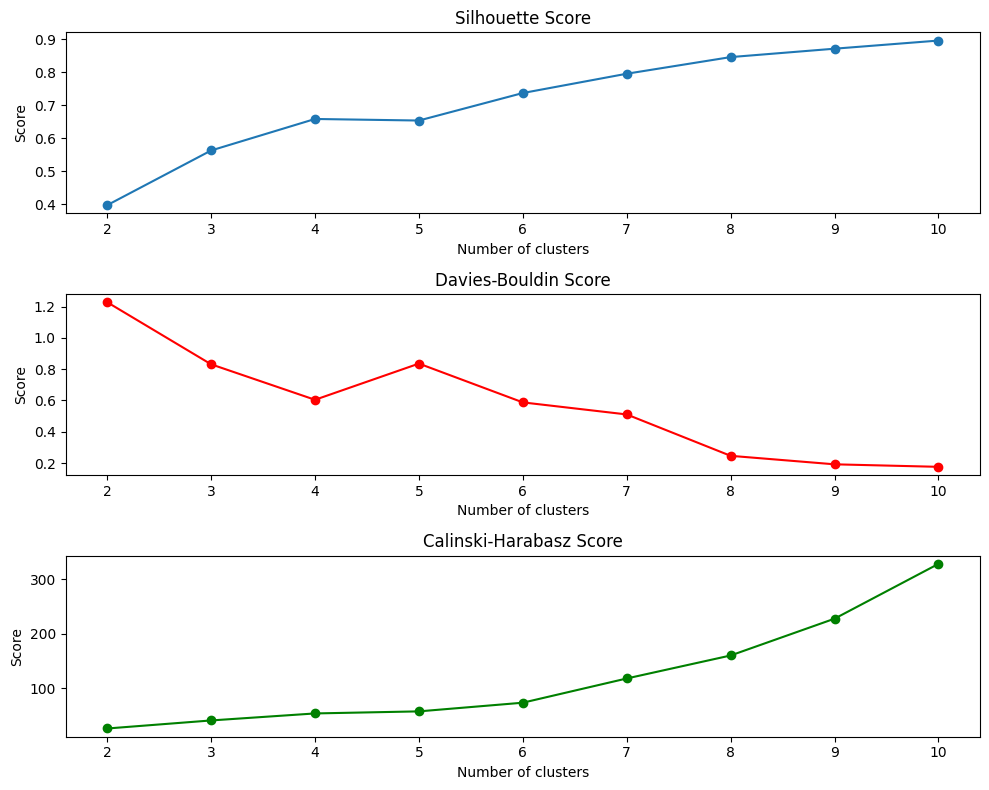

In [11]:
plot_clustering_scores(clustering_scores)

In [12]:
auto_process_id_assignment(df)

,Case,Activity,Variant,Timestamp,MorKeyb,Coor_X,Coor_Y,Click,features.experiment.GUI_category.name.TextInput,NameApp,Screenshot,header,combined_features,activity_label,process_id
0,1,1_A,3,10:00:29,1,610.0,279.0,1.0,1.0,Mail,1_img.png,inbox (56) - antonio.martinez,"[-0.008917087, -0.009882798, -0.011730575, -0....",1,1
1,1,2_B,3,10:00:31,0,NaN,NaN,1.0,1.0,Mail,2_img.png,proof of payment - antonio.martinez,"[-0.0075344113, -0.00045150172, -0.0040232735,...",0,1
2,1,3_C,3,10:00:33,1,640.0,364.0,NaN,NaN,Odoo,3_img.png,odoo - customers,"[-0.01456719, 0.010118167, -0.0059851324, 0.01...",3,1
3,1,4_D,3,10:00:35,1,1458.0,205.0,0.0,0.0,Odoo,4_img.png,"odoo - azure interior, brandon","[0.003930713, -0.01566362, 0.0029141922, 0.002...",2,1
4,1,5_F,3,10:00:37,0,NaN,NaN,NaN,NaN,Zendesk,5_img.png,inbox (56) - antonio.martinez,"[-0.0023092942, 0.0052374834, 0.0075386553, 0....",6,1
5,2,1_A,4,10:00:39,1,1352.0,509.0,1.0,1.0,Mail,6_img.png,inbox (56) - antonio.martinez,"[-0.0089797005, -0.010762121, -0.0105893, -0.0...",1,2
6,2,2_B,4,10:00:41,0,NaN,NaN,1.0,1.0,Mail,7_img.png,proof of payment - antonio.martinez,"[-0.0076332116, -0.00037805398, -0.0039250534,...",0,2
7,2,3_C,4,10:00:43,1,474.0,222.0,NaN,NaN,Odoo,8_img.png,odoo - customers,"[-0.01456719, 0.010118167, -0.0059851324, 0.01...",3,2
8,2,4_D,4,10:00:45,1,1196.0,215.0,0.0,0.0,Odoo,9_img.png,"odoo - azure interior, brandon","[0.0046096416, -0.014430532, 0.007100658, 0.00...",2,2
9,2,5_H,4,10:00:47,0,NaN,NaN,NaN,NaN,Odoo,10_img.png,"odoo - azure interior, brandon","[0.009046861, -0.0053495592, 0.0078368215, -0....",5,2


In [13]:
df.head()

,Case,Activity,Variant,Timestamp,MorKeyb,Coor_X,Coor_Y,Click,features.experiment.GUI_category.name.TextInput,NameApp,Screenshot,header,combined_features,activity_label,process_id
0,1,1_A,3,10:00:29,1,610.0,279.0,1.0,1.0,Mail,1_img.png,inbox (56) - antonio.martinez,"[-0.008917087, -0.009882798, -0.011730575, -0....",1,1
1,1,2_B,3,10:00:31,0,NaN,NaN,1.0,1.0,Mail,2_img.png,proof of payment - antonio.martinez,"[-0.0075344113, -0.00045150172, -0.0040232735,...",0,1
2,1,3_C,3,10:00:33,1,640.0,364.0,NaN,NaN,Odoo,3_img.png,odoo - customers,"[-0.01456719, 0.010118167, -0.0059851324, 0.01...",3,1
3,1,4_D,3,10:00:35,1,1458.0,205.0,0.0,0.0,Odoo,4_img.png,"odoo - azure interior, brandon","[0.003930713, -0.01566362, 0.0029141922, 0.002...",2,1
4,1,5_F,3,10:00:37,0,NaN,NaN,NaN,NaN,Zendesk,5_img.png,inbox (56) - antonio.martinez,"[-0.0023092942, 0.0052374834, 0.0075386553, 0....",6,1


### Resultados

In [14]:
def petri_net_process(df):
    formatted_df = pm4py.format_dataframe(df, case_id='process_id', activity_key='activity_label', timestamp_key='Timestamp')
    event_log = pm4py.convert_to_event_log(formatted_df)
    process_tree = inductive_miner.apply(event_log)
    net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
    dot = pn_visualizer.apply(net, initial_marking, final_marking)
    dot_path = os.path.join('results', 'pn.dot')
    with open(dot_path, 'w') as f:
        f.write(dot.source)

def bpmn_process(df):
    formatted_df = pm4py.format_dataframe(df, case_id='process_id', activity_key='activity_label', timestamp_key='Timestamp')
    event_log = pm4py.convert_to_event_log(formatted_df)
    bpmn_model = pm4py.discover_bpmn_inductive(event_log)
    dot = bpmn_visualizer.apply(bpmn_model)
    dot_path = os.path.join('results', 'bpmn.dot')
    with open(dot_path, 'w') as f:
        f.write(dot.source)
    bpmn_exporter.apply(bpmn_model, os.path.join('results', 'bpmn.bpmn'))

In [15]:
petri_net_process(df)
bpmn_process(df)

/tmp/ipykernel_1043/979115482.py:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  formatted_df = pm4py.format_dataframe(df, case_id='process_id', activity_key='activity_label', timestamp_key='Timestamp')
/screenrpa/venv/lib/python3.10/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/tmp/ipykernel_1043/979115482.py:12: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  formatted_df = pm4py.format_dataframe(df, case_id='process_id', activity_key='activity_label', timestamp_key='Timestamp')
/screenrpa/venv/lib/python3.10/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been de

### Verificacion

In [35]:
# Inicializar variables globales
current_cluster_images = []
current_image_index = 0

# Widgets
cluster_selector = widgets.Dropdown(options=sorted(df['activity_label'].unique()), description='Filtra Cluster:')
image_display = widgets.Output()
thumbnails_display = widgets.Output(layout={'width': '100%', 'overflow': 'scroll'})
image_counter = widgets.Label()
assign_cluster_input = widgets.Text(value='', description='Asigna Cluster:')
next_button = widgets.Button(description='Siguiente Imagen')
prev_button = widgets.Button(description='Imagen Anterior')
assign_button = widgets.Button(description='Asignar a Cluster')
metrics_display = widgets.Label()

In [36]:
def display_thumbnails(cluster):
    """Muestra las miniaturas de todas las imágenes del cluster seleccionado, incluyendo la etiqueta de activity_manual si existe."""
    global current_cluster_images
    with thumbnails_display:
        clear_output(wait=True)
        plt.figure(figsize=(20, 3))
        for idx, img_index in enumerate(current_cluster_images):
            img_path = os.path.join('resources', 'sc_0_size50_Balanced', df.loc[img_index, 'Screenshot'])
            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                plt.subplot(1, len(current_cluster_images), idx + 1)
                plt.imshow(img)
                # Verificar si la imagen tiene una etiqueta en activity_manual
                manual_label = df.loc[img_index, 'activity_manual']
                if pd.isna(manual_label) or manual_label == "":
                    title = f'#{idx+1} - NA'
                else:
                    title = f'#{idx+1} - {manual_label}'
                plt.title(title)
                plt.axis('off')
        plt.show()


def update_image_counter():
    """Actualiza el contador de imágenes para mostrar la posición actual en el cluster."""
    image_counter.value = f'Imagen {current_image_index + 1} de {len(current_cluster_images)}'

def display_current_image():
    """Muestra la imagen actual para la asignación de cluster."""
    global current_image_index
    with image_display:
        clear_output(wait=True)
        if current_cluster_images:
            img_path = os.path.join('resources', 'sc_0_size50_Balanced', df.loc[current_cluster_images[current_image_index], 'Screenshot'])
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
    update_image_counter()

def on_cluster_selected(change):
    """Actualiza la lista de imágenes y muestra las miniaturas al seleccionar un cluster."""
    global current_cluster_images, current_image_index
    current_cluster = change['new']
    current_cluster_images = df[df['activity_label'] == current_cluster].index.tolist()
    current_image_index = 0
    display_thumbnails(current_cluster)
    display_current_image()

def on_next_button_clicked(b):
    """Navega a la siguiente imagen del cluster."""
    global current_image_index
    if current_image_index < len(current_cluster_images) - 1:
        current_image_index += 1
    else:
        current_image_index = 0 
    display_current_image()

def on_prev_button_clicked(b):
    """Navega a la imagen anterior del cluster."""
    global current_image_index
    if current_image_index > 0:
        current_image_index -= 1
    else:
        current_image_index = len(current_cluster_images) - 1  # Opcional: ir al final si se desea un ciclo continuo
    display_current_image()

def on_assign_button_clicked(b):
    global current_cluster_images, current_image_index
    df.at[current_cluster_images[current_image_index], 'activity_manual'] = assign_cluster_input.value
    display_thumbnails(cluster_selector.value)
    
    # Calcular métricas después de cada asignación
    precision_actual = calcular_metricas()
    metrics_display.value = f'Precisión actual: {precision_actual:.2f}%'

def calcular_metricas():
    mapeo_manual_a_numerico = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}
    df['manual_numerico'] = df['activity_manual'].map(mapeo_manual_a_numerico)
    df['coincidencia'] = df['manual_numerico'] == df['activity_label']
    precision = df['coincidencia'].mean() * 100
    
    return precision


In [39]:
# Conexión de widgets a los botones
cluster_selector.observe(on_cluster_selected, names='value')
next_button.on_click(on_next_button_clicked)
prev_button.on_click(on_prev_button_clicked)
assign_button.on_click(on_assign_button_clicked)

# Mostrar los widgets
display(cluster_selector)
display(thumbnails_display)
display(image_display)
display(image_counter)
display(metrics_display)
display(widgets.HBox([prev_button, next_button, assign_cluster_input, assign_button]))

# Inicializar la visualización con el primer cluster
if df['activity_label'].unique().size > 0:
    current_cluster = cluster_selector.options[0]
    on_cluster_selected({'new': current_cluster})

Dropdown(description='Filtra Cluster:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0)

Output(layout=Layout(overflow='scroll', width='100%'), outputs=({'output_type': 'display_data', 'data': {'text…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 1 Axes>', 'i…

Label(value='Imagen 1 de 8')

Label(value='')

### Labbing

In [41]:
df['activity_manual'] = np.nan

In [25]:
new_column_order = [
    'Case', 'Activity', 'Variant', 'Timestamp', 'MorKeyb', 'Coor_X', 'Coor_Y', 
    'Click', 'features.experiment.GUI_category.name.TextInput', 'NameApp', 
    'Screenshot', 'header', 'combined_features', 'activity_manual', 'activity_label', 
    'process_id', 'case:concept:name', 'concept:name', 'time:timestamp'
]


df = df[new_column_order]

In [33]:
manual_assignments = ['A', 'A', 'D', 'C', 'G', 'A', 'A', 'D', 'C', 'F',
                      'F', 'A', 'A', 'D', 'C', 'F', 'F', 'A', 'A', 'D',
                      'C', 'H', 'A', 'A', 'D', 'C', 'H', 'A', 'A', 'D',
                      'C', 'I', 'J', 'E', 'A', 'A', 'D', 'C', 'G', 'A',
                      'A', 'D', 'C', 'I', 'J', 'E']

# Errores introducidos a propósito
manual_assignments[5] = 'B'  
manual_assignments[14] = 'E'  
manual_assignments[23] = 'B'  
manual_assignments[32] = 'F'  
manual_assignments[41] = 'B'  

# Asignar a la columna 'activity_manual'
df['activity_manual'] = manual_assignments

In [ ]:
if len(manual_assignments) != len(df):
    print(f"Error: La cantidad de asignaciones manuales ({len(manual_assignments)}) no coincide con la cantidad de filas del DataFrame ({len(df)}).")


manual_assignments.append('ValorExtra')  
df['activity_manual'] = manual_assignments


In [43]:
df.to_csv('resources/sc_0_size50_Balanced/log_exported.csv', sep=';', index=False, encoding='utf-8')